In [2]:
import sys
from pathlib import Path

In [3]:
%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

## imports

In [126]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

Reloading 'yolov1.models.model'.


In [127]:
import yolov1
from yolov1.config import parse_config

In [128]:
import numpy as np
import random

In [129]:
from yolov1.data.dataset import YOLODataset
from yolov1.utils.vis import draw_boxes_numpy,  draw_boxes_tensor
from yolov1.utils.general import decode_labels

## config

In [175]:
import pprint

In [176]:
def load_config(show=False):
    config_path = "../yolov1/src/yolov1/configs/default.yaml"
    config = parse_config(config_file=config_path)
    if show:
        pprint.pp(config.dict())
    return config

In [177]:
config = load_config()

## dataset

In [178]:
S, B, C = config.model.S, config.model.B, config.model.nc

In [179]:
S, B, C

(3, 2, 5)

In [180]:
train_ds = YOLODataset(config, mode="train", encode=True)

/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.venv/lib/python3.9/site-packages/pydantic/main.py:347: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


2024-05-16T21:20:03.774871Z [info     ] Loaded 878 samples             func_name=get_data lineno=88
2024-05-16T21:20:03.780729Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56


In [181]:
val_ds = YOLODataset(config, mode="valid", encode=True)

2024-05-16T21:20:03.906109Z [info     ] Loaded 250 samples             func_name=get_data lineno=88
2024-05-16T21:20:03.912786Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56


In [182]:
first = train_ds[11]

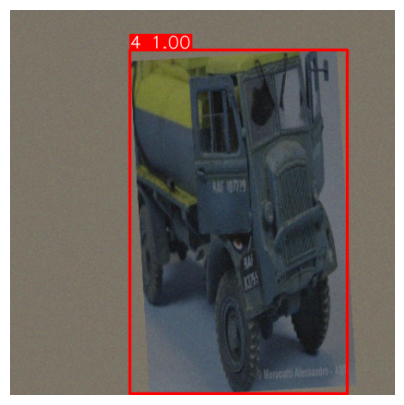

In [183]:
draw_boxes_tensor(first[0], decode_labels(first[1], S, B, C, nms=True))

In [184]:
len(train_ds[2])

2

In [185]:
sample = train_ds[4]

In [186]:
sample[0].shape

torch.Size([3, 448, 448])

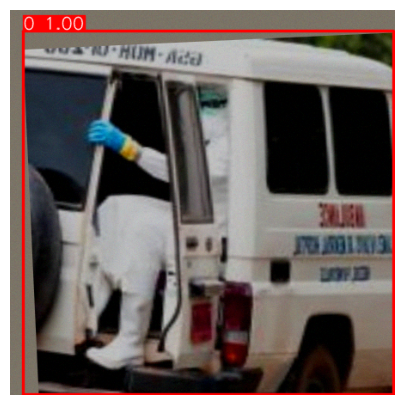

In [187]:
draw_boxes_tensor(
    sample[0],
    decode_labels(sample[1], config.model.S, config.model.B, config.model.nc))

In [188]:
val_ds = YOLODataset(config, mode="val")

2024-05-16T21:20:06.294585Z [info     ] Loaded 250 samples             func_name=get_data lineno=88
2024-05-16T21:20:06.301011Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56


## dataloader

In [189]:
from yolov1.data.utils import get_dls

In [190]:
train_dataloader = get_dls(config)

2024-05-16T21:20:07.087036Z [info     ] Loaded 878 samples             func_name=get_data lineno=88
2024-05-16T21:20:07.093650Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56


In [191]:
first = next(iter(train_dataloader))

In [192]:
decode_labels(first[1][0], S, B, C)

tensor([[3.0000, 0.5589, 0.4871, 0.8777, 0.9742, 1.0000, 1.0000],
        [3.0000, 0.7361, 0.3954, 0.5234, 0.7907, 1.0000, 1.0000]])

## arch

In [193]:
from yolov1.models.arch_v0 import YOLOv1

In [194]:
model = YOLOv1(config.model)

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [195]:
with torch.no_grad():
    out = model(first[0])

In [196]:
out.shape

torch.Size([3, 3, 3, 15])

In [197]:
first[1].shape

torch.Size([3, 3, 3, 15])

In [198]:
from yolov1.utils.loss import YOLOLoss

In [213]:
loss = YOLOLoss(config)

Reloading 'yolov1.utils.loss'.


In [214]:
for x in range(3):
    if not first[1][x].sum():
        print(x)
        break

In [218]:
loss_val = loss(out, first[1])

In [13]:
# model = YOLOv1(config.model)

## metrics

In [18]:
preds = [
 dict(
  boxes=torch.tensor([[258.0, 41.0, 606.0, 285.0], [258.0, 41.0, 606.0, 285.0], [214.0, 41.0, 562.0, 285.0]]),
     scores=torch.tensor([0.536, 0.8, 0.9]),
   labels=torch.tensor([0, 1, 0]),
  )
]
target = [
  dict(
  boxes=torch.tensor([[214.0, 41.0, 562.0, 285.0]]),
   labels=torch.tensor([0]),
  )
]

In [19]:
metric.update(preds, target)

In [20]:
metric.compute()

{'map': tensor(0.7010),
 'map_50': tensor(1.),
 'map_75': tensor(1.),
 'map_small': tensor(-1.),
 'map_medium': tensor(-1.),
 'map_large': tensor(0.7010),
 'mar_1': tensor(0.8000),
 'mar_10': tensor(0.8000),
 'mar_100': tensor(0.8000),
 'mar_small': tensor(-1.),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(0.8000),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([0, 1], dtype=torch.int32)}

In [11]:
MeanAveragePrecision?

Init signature:
MeanAveragePrecision(
    box_format: typing_extensions.Literal['xyxy', 'xywh', 'cxcywh'] = 'xyxy',
    iou_type: Union[typing_extensions.Literal['bbox', 'segm'], Tuple[str]] = 'bbox',
    iou_thresholds: Optional[List[float]] = None,
    rec_thresholds: Optional[List[float]] = None,
    max_detection_thresholds: Optional[List[int]] = None,
    class_metrics: bool = False,
    extended_summary: bool = False,
    average: typing_extensions.Literal['macro', 'micro'] = 'macro',
    backend: typing_extensions.Literal['pycocotools', 'faster_coco_eval'] = 'pycocotools',
    **kwargs: Any,
) -> None
Docstring:     
Compute the `Mean-Average-Precision (mAP) and Mean-Average-Recall (mAR)`_ for object detection predictions.

.. math::
    \text{mAP} = \frac{1}{n} \sum_{i=1}^{n} AP_i

where :math:`AP_i` is the average precision for class :math:`i` and :math:`n` is the number of classes. The average
precision is defined as the area under the precision-recall curve. For object detec

## train

In [226]:
config = load_config()

Reloading 'yolov1.utils.loss'.


In [227]:
from yolov1.train import main

In [228]:
main(config)

2024-05-16T21:43:45.845631Z [info     ] Loaded 878 samples             func_name=get_data lineno=88
2024-05-16T21:43:45.852591Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56
2024-05-16T21:43:45.905820Z [info     ] Loaded 250 samples             func_name=get_data lineno=88
2024-05-16T21:43:45.913134Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56
Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


INFO: Using 16bit Automatic Mixed Precision (AMP)


Using 16bit Automatic Mixed Precision (AMP)


INFO: GPU available: True (cuda), used: True


GPU available: True (cuda), used: True


INFO: TPU available: False, using: 0 TPU cores


TPU available: False, using: 0 TPU cores


INFO: IPU available: False, using: 0 IPUs


IPU available: False, using: 0 IPUs


INFO: HPU available: False, using: 0 HPUs


HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INFO: 
  | Name       | Type                 | Params
----------------------------------------------------
0 | model      | YOLOv1               | 16.3 M
1 | criterion  | YOLOLoss             | 0     
2 | map_metric | MeanAveragePrecision | 0     
----------------------------------------------------
5.2 M     Trainable params
11.2 M    Non-trainable params
16.3 M    Total params
65.391    Total estimated model params size (MB)



  | Name       | Type                 | Params
----------------------------------------------------
0 | model      | YOLOv1               | 16.3 M
1 | criterion  | YOLOLoss             | 0     
2 | map_metric | MeanAveragePrecision | 0     
----------------------------------------------------
5.2 M     Trainable params
11.2 M    Non-trainable params
16.3 M    Total params
65.391    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.venv/lib/python3.9/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## infer

In [229]:
from yolov1.detect import main as detect_main
from yolov1.data.dataset import InferenceDataset
from yolov1.data.utils import get_dls_for_inference

In [230]:
config.inference.source = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/.data/test/images'

In [231]:
config.inference.checkpoint = '/home/ajkdrag/workspace/projects/architectures-impl-pytorch/checkpoints/epoch_epoch=19_val_mAP=0.06.ckpt'

In [238]:
for idx, res in enumerate(detect_main(config)):
    if idx == 1:
        break

Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-05-16T21:47:24.066102Z [info     ] Model loaded successfully      func_name=main lineno=66
2024-05-16T21:47:24.074381Z [info     ] Class weights: [0.4, 0.24, 0.12, 0.36, 0.32] func_name=_set_class_weights lineno=56


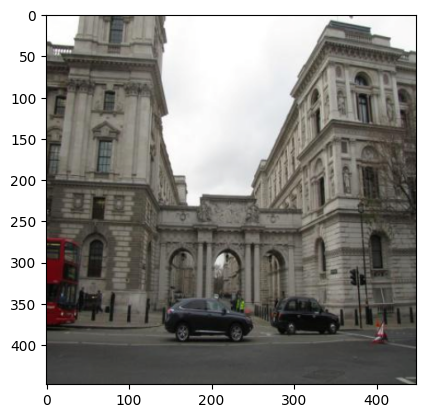

In [242]:
plt.imshow(res["drawn"][0])